# Data Analysis: Loan Approval Classification

### Objective: 
- To enhance expertise in data management

- To manage data appropriately for practical use.

- To apply Machine Learning models: KNN, Decision Tree, Random Forest, Naive Bayes, and Logistic Regression.

- To evaluate and compare model performance

### 1. Data Management

Data Exploration

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [116]:
# Load the dataset
df = pd.read_csv("loan_data.csv")
print("Shape:", df.shape)
df.head()

Shape: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Handling missing values & duplicates

In [117]:
# Handle missing values
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])

In [118]:
# Handle duplicates
df = df.drop_duplicates()

Encode categorical data

In [119]:
target = "loan_status"
X = df.drop(columns=[target])
y = df[target]

# Label encoding for all categorical columns
for col in X.select_dtypes(exclude=[np.number]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

In [120]:
# encode target
y = LabelEncoder().fit_transform(y.astype(str))

### 2. Sampling Strategy

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 3. Data Scaling

In [122]:
# scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

### 4. Model Training

In [123]:
results = {}

### 4.1 K-Nearest Neighbors (KNN) Algorithm

In [124]:
best_acc = 0
best_k = 0
for k in range(3, 16, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    acc = knn.score(X_test_s, y_test)
    if acc > best_acc:
        best_acc, best_k = acc, k

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_s, y_train)
y_pred_knn = knn.predict(X_test_s)
y_proba_knn = knn.predict_proba(X_test_s)

results["KNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn, average='weighted'),
    "Recall": recall_score(y_test, y_pred_knn, average='weighted'),
    "F1": f1_score(y_test, y_pred_knn, average='weighted'),
    "AUC": roc_auc_score(y_test, y_proba_knn[:,1]) if len(np.unique(y))==2 else np.nan
}

### 4.2 Decision Tree Algorithm

In [125]:
param = {'max_depth':[3,5,8,None], 'min_samples_split':[2,5,10]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param, cv=3)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.best_estimator_.predict_proba(X_test)

results["Decision Tree"] = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt, average='weighted'),
    "Recall": recall_score(y_test, y_pred_dt, average='weighted'),
    "F1": f1_score(y_test, y_pred_dt, average='weighted'),
    "AUC": roc_auc_score(y_test, y_proba_dt[:,1]) if len(np.unique(y))==2 else np.nan
}

### 4.3 Random Forest Algorithm

In [126]:
rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    {'n_estimators':[50,100], 'max_depth':[10,None], 'min_samples_split':[2,5]},
    cv=3
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.best_estimator_.predict_proba(X_test)

results["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, average='weighted'),
    "Recall": recall_score(y_test, y_pred_rf, average='weighted'),
    "F1": f1_score(y_test, y_pred_rf, average='weighted'),
    "AUC": roc_auc_score(y_test, y_proba_rf[:,1]) if len(np.unique(y))==2 else np.nan
}

### 4.4 Naive Bayes Algorithm

In [127]:
nb = GaussianNB()
nb.fit(X_train_s, y_train)
y_pred_nb = nb.predict(X_test_s)
y_proba_nb = nb.predict_proba(X_test_s)

results["Naive Bayes"] = {
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb, average='weighted'),
    "Recall": recall_score(y_test, y_pred_nb, average='weighted'),
    "F1": f1_score(y_test, y_pred_nb, average='weighted'),
    "AUC": roc_auc_score(y_test, y_proba_nb[:,1]) if len(np.unique(y))==2 else np.nan
}

### 4.5 Logistic Regression Algorithm

In [128]:
lr = GridSearchCV(
    LogisticRegression(max_iter=500, solver="liblinear", random_state=42),
    {'C':[0.01,0.1,1,10], 'penalty':['l1','l2']},
    cv=3
)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
y_proba_lr = lr.best_estimator_.predict_proba(X_test_s)

results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average='weighted'),
    "Recall": recall_score(y_test, y_pred_lr, average='weighted'),
    "F1": f1_score(y_test, y_pred_lr, average='weighted'),
    "AUC": roc_auc_score(y_test, y_proba_lr[:,1]) if len(np.unique(y))==2 else np.nan
}

### 5. Model Evaluation & Comparison

In [129]:
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1,AUC
KNN,0.898444,0.895843,0.898444,0.896592,0.946354
Decision Tree,0.918111,0.916919,0.918111,0.914630,0.962931
Random Forest,0.927667,0.926236,0.927667,0.925804,0.973792
Naive Bayes,0.736333,0.878895,0.736333,0.758519,0.941685
Logistic Regression,0.897778,0.896261,0.897778,0.896889,0.950861


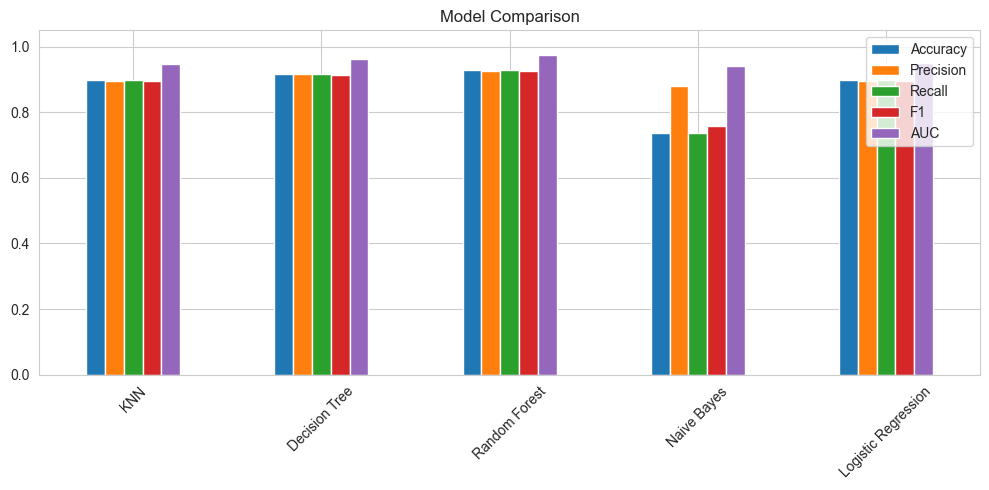

In [130]:
results_df.plot(kind="bar", figsize=(10,5), ylim=(0,1.05), rot=45, title="Model Comparison")
plt.tight_layout()
plt.show()

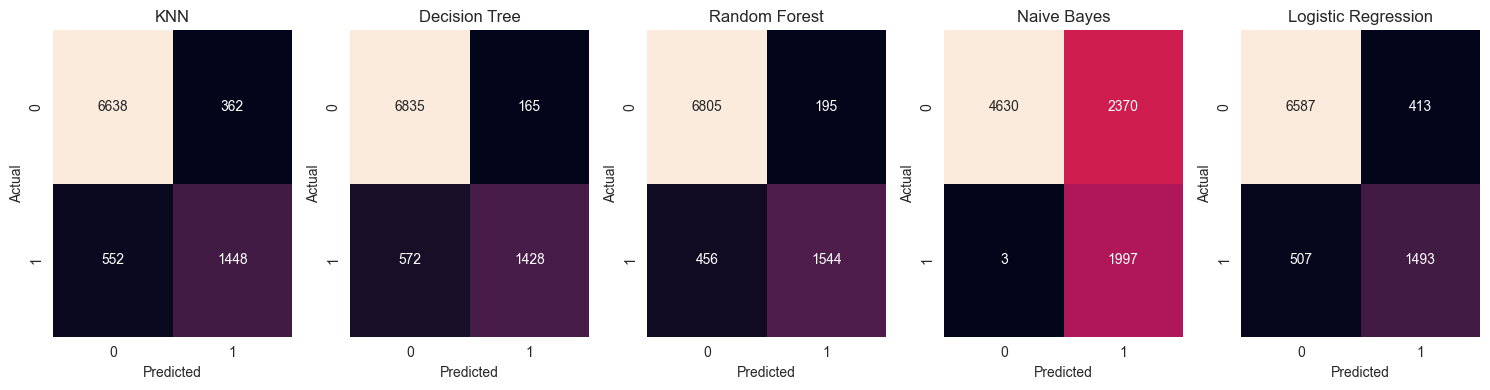

In [131]:
# Confusion Matrices
models_preds = {
    "KNN": y_pred_knn,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Naive Bayes": y_pred_nb,
    "Logistic Regression": y_pred_lr
}

plt.figure(figsize=(15,4))
for i, (name, preds) in enumerate(models_preds.items()):
    plt.subplot(1, len(results), i+1)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
plt.tight_layout()
plt.show()

From the comparison, each model demonstrated unique strengths:
- KNN performed well with standardized data but was sensitive to feature scaling and choice of k.

- Decision Tree offered high interpretability but risked overfitting without proper depth control.

- Random Forest provided strong generalization and balanced performance across all metrics.

- Naive Bayes was computationally efficient and effective with normally distributed features.

- Logistic Regression showed stable performance with good interpretability on linearly separable data.

### 6. Conclusion

- This project demonstrated the full process of building and evaluating classification models, emphasizing the importance of data cleaning, preprocessing, and model comparison.

- The results show that proper data preparation and systematic evaluation improve model reliability, with insights applicable to real-world machine learning tasks.